# How to Build an ARX Model

In [26]:
import numpy as np
import pandas as pd 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

import numpy as np

def generate_siso_data(n, noise_level=0.1, a1=0.5, a2=-0.3, b1=0.7, b2=-0.2):
    """
    Generates synthetic Single Input Single Output (SISO) data for an ARX model with na=2 and nb=2.
    :param n: Number of data points to generate.
    :param noise_level: Standard deviation of the noise.
    :param a1, a2: Coefficients for the autoregressive part of the model.
    :param b1, b2: Coefficients for the exogenous input part of the model.
    :return: Tuple of (y, x), where y is the target series and x is the exogenous series.
    """
    # Generating exogenous input (x) as a random signal
    x = np.random.randint(0, 2, size=n)

    # Generating the target series (y)
    y = np.zeros(n)
    for t in range(2, n):
        y[t] = a1 * y[t-1] + a2 * y[t-2] + b1 * x[t-1] + b2 * x[t-2] + np.random.normal(0, noise_level)

    return y, x


def fit_arx_model(y, x, na, nb):
    """
    Fits an ARX model to the given data and returns the coefficients of A, B, and the intercept.
    :param y: Target time series.
    :param x: Exogenous time series.
    :param na: Order of the autoregressive part.
    :param nb: Order of the exogenous input part.
    :return: Coefficients of A, B and the intercept of the ARX model.
    """
    max_lag = max(na, nb)
    features = []
    target = y[max_lag:]

    for i in range(max_lag, len(y)):
        lag_y = y[i-na:i] if na > 0 else []
        lag_x = x[i-nb:i] if nb > 0 else []
        row = np.concatenate([lag_y, lag_x])
        features.append(row)

    X = np.array(features)
    model = LinearRegression().fit(X, target)
    return model.coef_[:na], model.coef_[na:], model.intercept_

y, x = generate_siso_data(n=100, noise_level=0.05)

# Fit ARX model and get A, B coefficients and intercept
na, nb = 2, 2
coefficients_a, coefficients_b, intercept = fit_arx_model(y, x, na, nb)

our_linear_model_results = pd.DataFrame({
    'Regressors': [f'y(t-{i})' for i in reversed(range(1, na+1))] + [f'x(t-{i})' for i in reversed(range(1, nb+1))] + ['1'],
    'Parameters': list(coefficients_a) + list(coefficients_b) + [intercept],
    'Source': 'NumPy Model'
}).set_index("Regressors").sort_index()

In [27]:
our_linear_model_results["Parameters"]

Regressors
1        -0.014105
x(t-1)    0.708612
x(t-2)   -0.184896
y(t-1)    0.484985
y(t-2)   -0.284102
Name: Parameters, dtype: float64

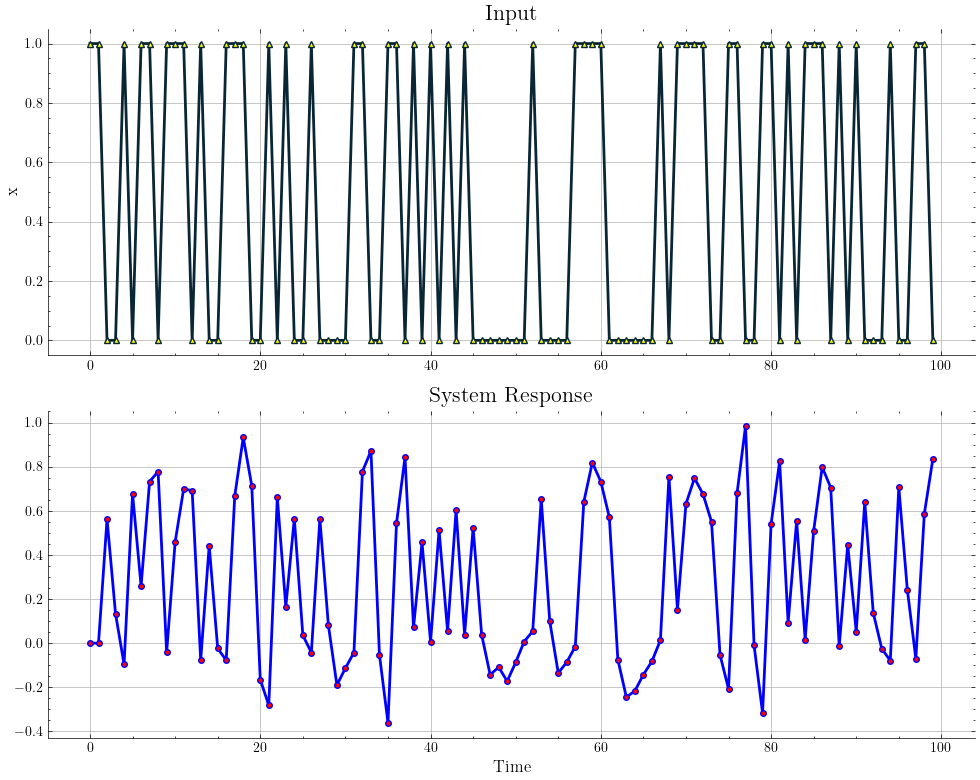

In [28]:

# Creating a 2-row plot for x and y
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plotting x
axes[0].plot(x, color='#092635', linewidth=2, linestyle='-', marker='^', markersize=4, markerfacecolor='yellow')
axes[0].set_title('Input', fontsize=16)
axes[0].set_ylabel('x', fontsize=12)
axes[0].grid(True)

# Plotting y
axes[1].plot(y, color='blue', linewidth=2, linestyle='-', marker='o', markersize=4, markerfacecolor='red')
axes[1].set_title('System Response', fontsize=16)
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylabel('', fontsize=12)
axes[1].grid(True)

# Adjust layout
plt.tight_layout()

# Save the plots as a PDF
#plt.savefig('../img/response.pdf', format='pdf')

plt.show()

In [29]:

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial


In [30]:
basis_function = Polynomial(degree=1)

model = FROLS(
    order_selection=False,
    n_terms=5,
    extended_least_squares=False,
    ylag=2,
    xlag=2,
    estimator="least_squares",
    basis_function=basis_function,
)

model.fit(X=x.reshape(-1,1), y=y.reshape(-1,1))

/home/alqua/anaconda3/envs/dl_env/lib/python3.10/site-packages/sysidentpy/narmax_base.py:170: RuntimeWarning: divide by zero encountered in divide
  x = x[1:] / aux_b
/home/alqua/anaconda3/envs/dl_env/lib/python3.10/site-packages/sysidentpy/narmax_base.py:198: RuntimeWarning: invalid value encountered in multiply
  w = b * np.dot(RA.T, v)


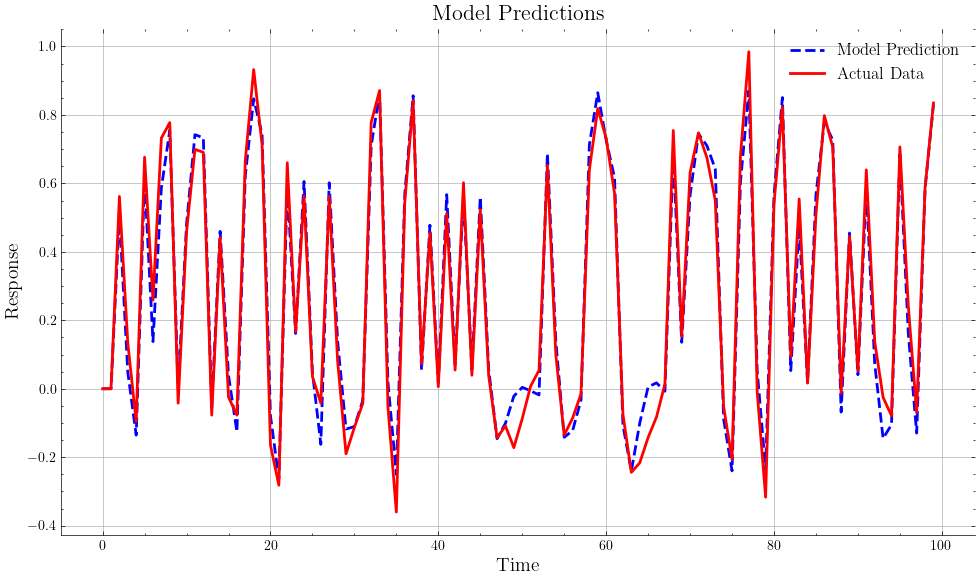

In [33]:
yhat = model.predict(X=x.reshape(-1,1), y=y.reshape(-1,1)).squeeze()

plt.figure(figsize=(10, 6))
plt.plot(yhat, label='Model Prediction', color='blue', linewidth=2, linestyle='--')
plt.plot(y, label='Actual Data', color='red', linewidth=2)

# Enhancing the plot with additional features
plt.title('Model Predictions', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Response', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

#plt.savefig('response_yhat.pdf', format='pdf')
plt.show()

In [ ]:
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

In [ ]:
sysidentpy_model_results = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=2,
        dtype="dec",
    ),
    columns=["Regressors", "Parameters", "ERR"],
).set_index("Regressors").sort_index()

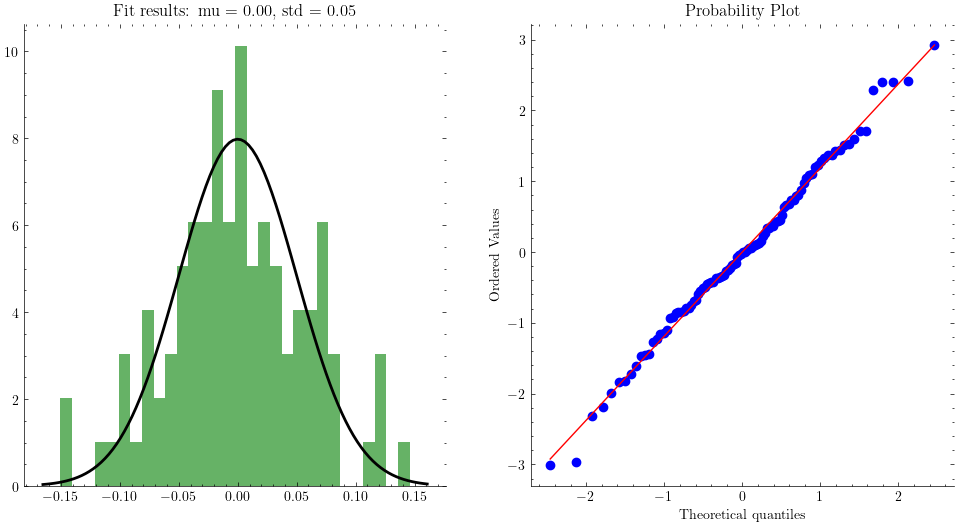

Shapiro-Wilk test result: ShapiroResult(statistic=0.9933208227157593, pvalue=0.9066401720046997)


In [43]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Assuming y and yhat are your actual and predicted values, which should be numpy arrays
# Calculate residuals
residuals = y - yhat

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(residuals)

# Compare with a Gaussian distribution
mu = 0
sigma = 0.05
z_scores = (residuals - mu) / sigma

# Plotting
plt.figure(figsize=(12, 6))

# Histogram of the residuals
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)

# QQ plot
plt.subplot(1, 2, 2)
stats.probplot(z_scores, dist="norm", plot=plt)
plt.show()

# Output the results of the Shapiro-Wilk test
print("Shapiro-Wilk test result:", shapiro_test)


In [44]:
# Determine if residuals are compatible with Gaussian distribution
p_value_threshold = 0.05
if shapiro_test[1] > p_value_threshold:
    print("The residuals are compatible with a Gaussian distribution.")
else:
    print("The residuals are not compatible with a Gaussian distribution.")

The residuals are compatible with a Gaussian distribution.


In [50]:
from matplotlib.backends.backend_pdf import PdfPages

residuals = y - yhat

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(residuals)

# Compare with a Gaussian distribution
mu = 0
sigma = 0.05
z_scores = (residuals - mu) / sigma

# Creating a PDF file to save plots
pdf = PdfPages("../img/residuals_analysis.pdf")

# Plotting in a more aesthetic manner
plt.figure(figsize=(12, 6))

# Histogram of the residuals
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
plt.title("Residuals Histogram", fontsize=14)
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Density", fontsize=12)

# QQ plot
plt.subplot(1, 2, 2)
stats.probplot(z_scores, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot", fontsize=14)
plt.xlabel("Theoretical Quantiles", fontsize=12)

# Saving the figure to PDF
pdf.savefig()
plt.close()

# Closing the PDF object
pdf.close()

# Output the results of the Shapiro-Wilk test
shapiro_result = f"Shapiro-Wilk test result: statistic={shapiro_test[0]:.4f}, p-value={shapiro_test[1]:.4f}"
compatibility_result = "The residuals are compatible with a Gaussian distribution." if shapiro_test[1] > 0.05 else "The residuals are not compatible with a Gaussian distribution."
print(f"Shapiro-Wilk test result: statistic={shapiro_test[0]:.4f}, p-value={shapiro_test[1]:.4f}")
print("The residuals are compatible with a Gaussian distribution." if shapiro_test[1] > 0.05 else "The residuals are not compatible with a Gaussian distribution.")

Shapiro-Wilk test result: statistic=0.9933, p-value=0.9066
The residuals are compatible with a Gaussian distribution.


In [52]:
sysidentpy_model_results["Parameters"]

Regressors
1           0.0115
x1(k-1)     0.7034
x1(k-2)    -0.1962
y(k-1)      0.4883
y(k-2)     -0.3367
Name: Parameters, dtype: object

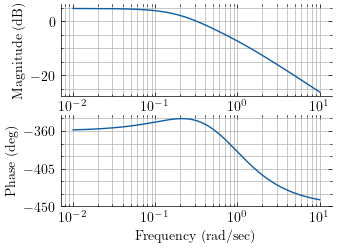

In [53]:
import numpy as np
import control.matlab as control
import matplotlib.pyplot as plt

# ARX model coefficients
a1 = 0.7034
a2 = -0.1962
b1 = 0.4883
b2 = -0.3367

# Transfer function coefficients
num = [b1, b2]
den = [1, a1, a2]

# Create transfer function
sys = control.tf(num, den)

# Bode plot
mag, phase, omega = control.bode(sys)

In [54]:
model.

'aic'

# Order Selection

In [61]:
y, x = generate_siso_data(n=100, noise_level=0.05)

y, x = y.reshape(-1,1), x.reshape(-1,1)
y_valid, x_valid = y,x

/home/alqua/anaconda3/envs/dl_env/lib/python3.10/site-packages/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 17 
  self.info_values = self.information_criterion(reg_matrix, y)


0.12958727883748045
  Regressors   Parameters             ERR
0    x1(k-1)   7.2601E-01  9.09338982E-01
1     y(k-2)  -2.9677E-01  4.05401852E-02
2     y(k-1)   2.7138E-01  3.34910378E-02
3    x1(k-2)  -3.6061E-02  6.37879359E-03
4     y(k-4)  -4.5636E-02  3.01053375E-04
5    x1(k-4)  -4.2204E-02  3.39735391E-04
6     y(k-6)   1.8619E-02  2.36453204E-04


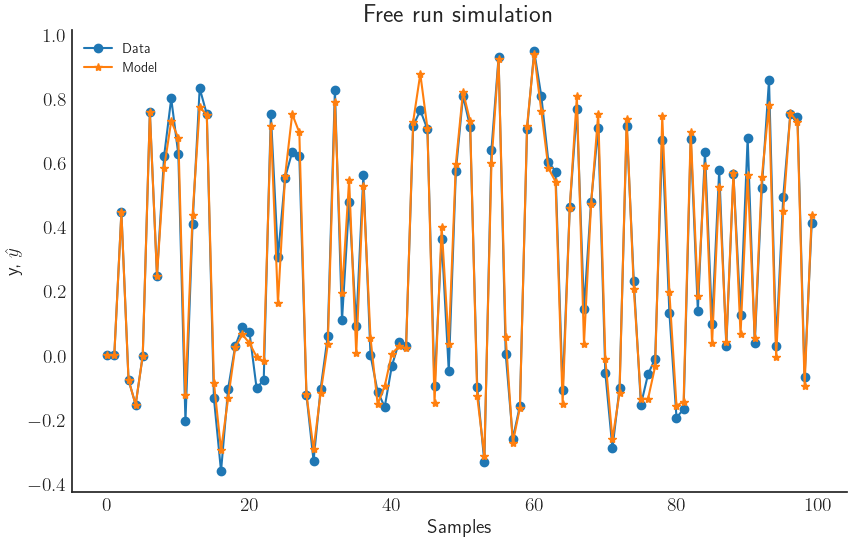

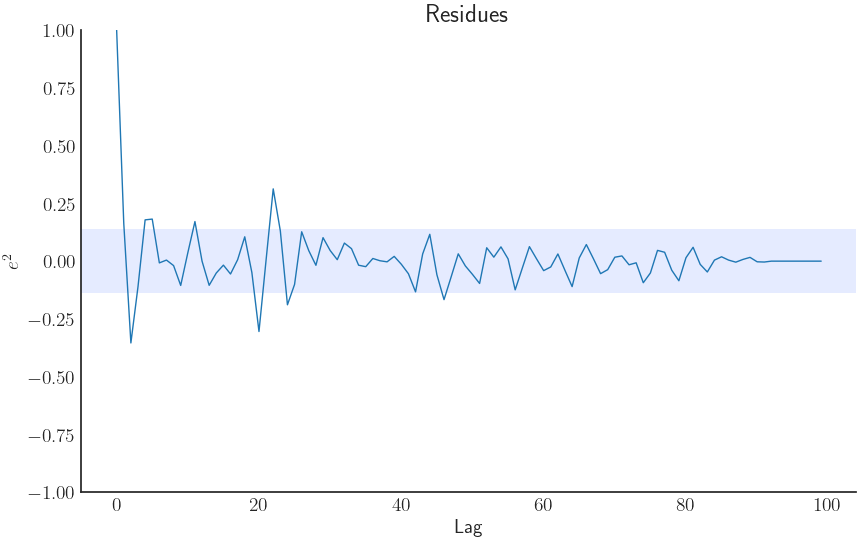

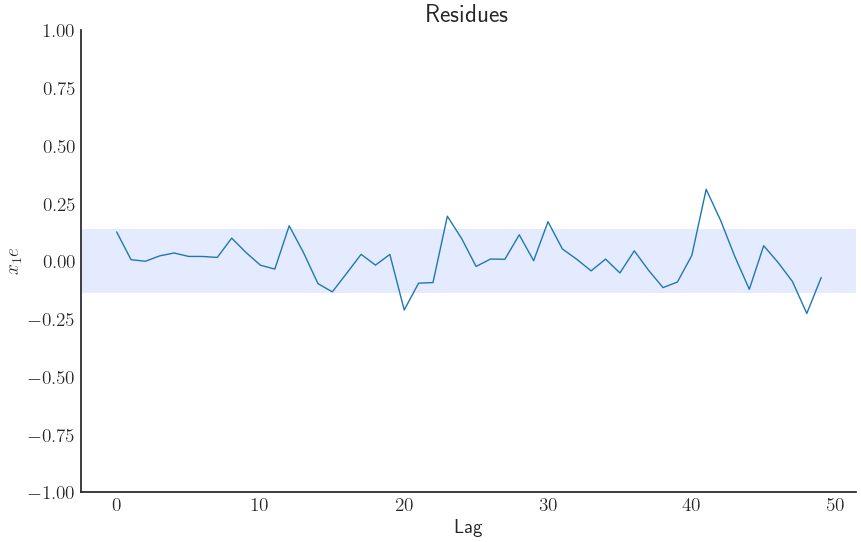

Text(0, 0.5, 'Information Criteria')

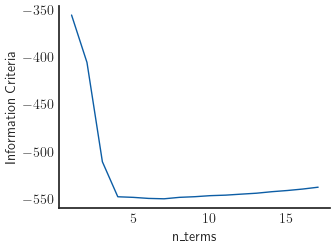

In [67]:
basis_function = Polynomial(degree=1)

model = FROLS(
    order_selection=True,
    n_info_values=30,
    extended_least_squares=False,
    ylag=8,
    xlag=8,
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
)
model.fit(X=x, y=y)
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)
plot_results(y=y_valid, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

xaxis = np.arange(1, model.n_info_values + 1)
plt.plot(xaxis, model.info_values)
plt.xlabel("n_terms")
plt.ylabel("Information Criteria")

In [68]:

model.info_values

array([-355.96522098, -406.06673889, -511.00783352, -547.996635  ,
       -548.63053222, -549.74519517, -550.14612642, -548.61879527,
       -547.93027847, -546.83318621, -546.28236767, -545.23319816,
       -544.24173051, -542.64307804, -541.38825573, -539.83941753,
       -537.89003979])